<a href="https://colab.research.google.com/github/iwatadive28/ESC-50-1DCNN/blob/main/ESC_50_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 環境の準備
Google Colabでの設定
Colabを開き、GPUを有効にします。
メニューから「ランタイム」 > 「ランタイムのタイプを変更」 > 「ハードウェア アクセラレータ」 > 「GPU」を選択。
必要なライブラリのインストール
以下を実行して、必要なライブラリをインストールします。



In [1]:
!pip install tensorflow librosa numpy matplotlib

# 2. データセットのダウンロード
ESC-50データセットをダウンロードして解凍します。

In [10]:
from google.colab import drive
import os
import zipfile
import urllib.request

# Google Driveをマウント
drive.mount('/content/drive')

# データセットの保存先フォルダをGoogle Drive内に設定
drive_data_dir = "/content/drive/MyDrive/Colab Notebooks/ESC-50-1DCNN"
os.makedirs(drive_data_dir, exist_ok=True)

# 保存先フォルダに移動
os.chdir(drive_data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# ESC-50データセットのダウンロード
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
data_dir = "./ESC-50/"
zip_path = os.path.join(data_dir, "ESC-50.zip")

# データセットがまだダウンロードされていない場合のみダウンロード
if not os.path.exists(zip_path):
    print("データセットをダウンロード中...")
    urllib.request.urlretrieve(url, zip_path)
    print("ダウンロード完了！")

# 解凍
print("データセットを解凍中...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)

print("データセットの準備完了！")

データセットを解凍中...
データセットの準備完了！


# 3. 前処理
データとラベルの準備
ESC-50フォルダ内の音声ファイルをロードします。
ラベルを抽出し、データを分割します。

In [ ]:
"""
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# メタデータを読み込む
metadata_path = "./ESC-50/ESC-50-master/meta/esc50.csv"
metadata = pd.read_csv(metadata_path)

# パラメータ設定
SAMPLE_RATE = 16000  # サンプリングレート
DURATION = 5         # 音声の長さ（秒）

# 音声データのロード関数
def load_audio(file_path, label, sr=SAMPLE_RATE, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    # 長さを統一（ゼロパディング）
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))
    return y, label

# データ準備
audio_data = []
labels = []

base_path = "./ESC-50/ESC-50-master/audio/"
for index, row in metadata.iterrows():
    file_path = os.path.join(base_path, row["filename"])
    label = row["category"]
    y, lbl = load_audio(file_path, label)
    audio_data.append(y)
    labels.append(lbl)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=0.2, random_state=42)
"""

「人の声や行動」とそれ以外に分類

- binary_label = 1: 「人の声や行動」に該当する音声。
  ラベルがhuman_labelsに含まれている場合。
  該当ラベル: 'laughing', 'crying_baby', 'sneezing', 'snoring', 'clapping', 'breathing', 'coughing', 'footsteps'
- binary_label = 0: それ以外。ラベルがhuman_labelsに含まれていない場合。

In [15]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# メタデータを読み込む
metadata_path = os.path.join(data_dir, "ESC-50-master/meta/esc50.csv")
metadata = pd.read_csv(metadata_path)

# パラメータ設定
SAMPLE_RATE = 16000  # サンプリングレート
DURATION = 5         # 音声の長さ（秒）

# 「人の声や行動」に該当するラベルリスト
human_labels = [
    'laughing', 'crying_baby', 'sneezing', 'snoring', 'clapping', 'breathing', 'coughing', 'footsteps'
]

# 音声データのロード関数（正規化追加）
def load_audio(file_path, label, sr=SAMPLE_RATE, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    # 長さを統一（ゼロパディング）
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))
    # 正規化
    y = y / np.max(np.abs(y))
    # ラベルを二値化
    binary_label = 1 if label in human_labels else 0
    return y, binary_label

# データ準備
audio_data = []
labels = []

# base_path = "./ESC-50/ESC-50-master/audio/"
base_path = os.path.join(data_dir, "ESC-50-master/audio/")
for index, row in metadata.iterrows():
    file_path = os.path.join(base_path, row["filename"])
    label = row["category"]
    y, lbl = load_audio(file_path, label)
    audio_data.append(y)
    labels.append(lbl)

In [16]:
# データ拡張（ノイズ追加の例）
def augment_audio(y, method="noise"):
    if method == "noise":
        noise = np.random.normal(0, 0.005, len(y))  # ホワイトノイズ
        y_aug = y + noise
    elif method == "volume":
        factor = np.random.uniform(0.8, 1.2)  # 音量調整
        y_aug = y * factor
    elif method == "pitch":
        y_aug = librosa.effects.pitch_shift(y, sr=SAMPLE_RATE, n_steps=np.random.uniform(-2, 2))  # ピッチシフト
    return y_aug

# ラベルが少ないクラスを拡張
augmented_audio_data = []
augmented_labels = []
for y, lbl in zip(audio_data, labels):
    if lbl == 1:  # 少数クラスを対象
        for _ in range(5):  # 5倍に増加
            y_aug = augment_audio(y, method="noise")
            augmented_audio_data.append(y_aug)
            augmented_labels.append(lbl)

augmented_audio_data.extend(audio_data)
augmented_labels.extend(labels)

print(f"拡張前データ: {len(audio_data)} サンプル")
print(f"拡張後データ: {len(augmented_audio_data)} サンプル")

拡張前データ: 2000 サンプル
拡張後データ: 3600 サンプル


In [17]:
# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    augmented_audio_data, augmented_labels, test_size=0.2, random_state=42
)

# 結果確認
print(f"訓練データ: {len(X_train)} サンプル")
print(f"テストデータ: {len(X_test)} サンプル")
print(f"クラス分布 (訓練データ): {np.bincount(y_train)}")  # クラスの分布を確認
print(f"クラス分布 (テストデータ): {np.bincount(y_test)}")

訓練データ: 2880 サンプル
テストデータ: 720 サンプル
クラス分布 (訓練データ): [1358 1522]
クラス分布 (テストデータ): [322 398]


# 4. モデル構築
1D-CNNを使用したモデルを構築します。

In [18]:
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# ラベルをエンコード
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# モデル構築
model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(SAMPLE_RATE * DURATION, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(encoder.classes_), activation='softmax')
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 79998, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 39999, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 39997, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19998, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 19996, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,674 (612.01 KB)

 Trainable params: 156,674 (612.01 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
!pip install pydot graphviz

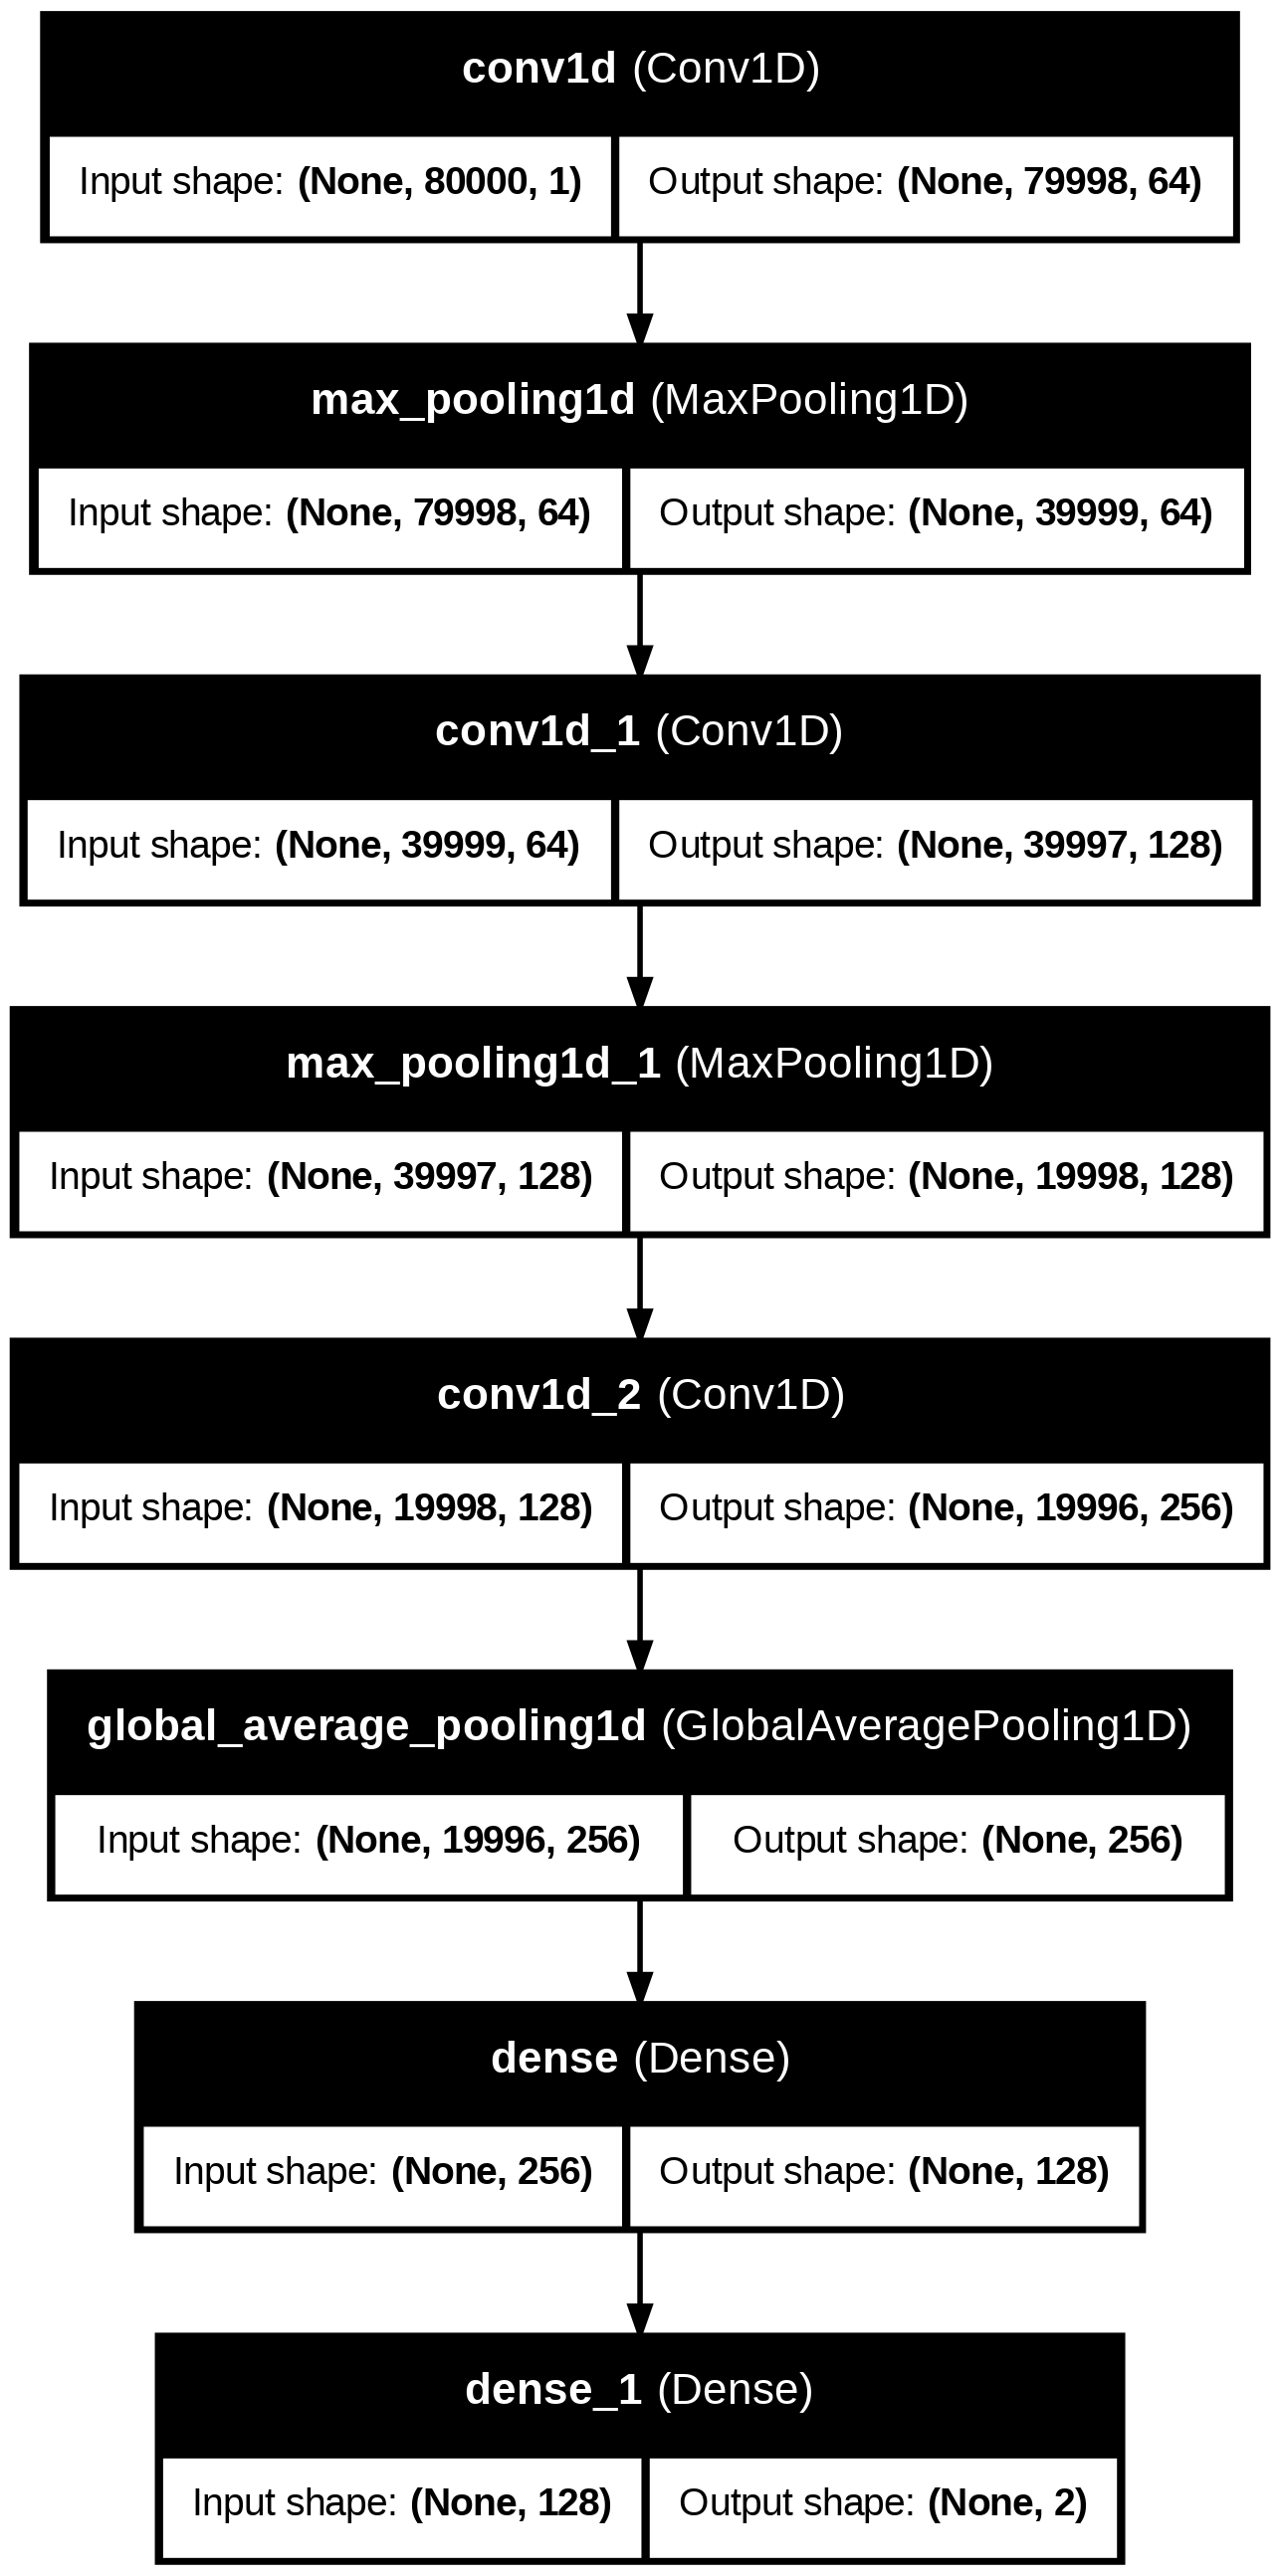

In [21]:
from tensorflow.keras.utils import plot_model
# モデル構造図の表示
plot_model(
    model,
    to_file="model_structure.png",  # ファイルに保存
    show_shapes=True,  # 入力と出力の形状を表示
    show_layer_names=True  # レイヤー名を表示
)

# Notebook内で画像を表示（小さく表示）
from IPython.display import Image
Image("model_structure.png", width=400)  # 幅を400ピクセルに指定


# 5. データの準備と訓練
データをモデルに適した形式に変換して訓練します。

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# データの形状を確認
print(f"X_train shape before reshaping: {np.array(X_train).shape}")
print(f"y_train_enc shape: {np.array(y_train_enc).shape}")

# 入力データの形状を修正
X_train = np.array(X_train).reshape(-1, SAMPLE_RATE * DURATION, 1)
X_test = np.array(X_test).reshape(-1, SAMPLE_RATE * DURATION, 1)

# ラベルをNumPy配列に変換
y_train_enc = np.array(y_train_enc)
y_test_enc = np.array(y_test_enc)

# 修正後の形状を確認
print(f"X_train shape after reshaping: {X_train.shape}")
print(f"y_train_enc shape: {y_train_enc.shape}")

# モデルの保存先パス
MODEL_SAVE_PATH = "trained_1d_cnn_model.keras"

# モデルの訓練時に保存するコールバック
# EarlyStopping と ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# モデルの訓練
history = model.fit(
    X_train,
    y_train_enc,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test_enc),
    callbacks=[checkpoint, early_stopping]
)

# 最終モデルの保存
model.save(MODEL_SAVE_PATH)
print(f"モデルを保存しました: {MODEL_SAVE_PATH}")

X_train shape before reshaping: (2880, 80000)
y_train_enc shape: (2880,)
X_train shape after reshaping: (2880, 80000, 1)
y_train_enc shape: (2880,)
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6045 - loss: 0.6554
Epoch 1: val_loss improved from inf to 0.64353, saving model to trained_1d_cnn_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 617ms/step - accuracy: 0.6047 - loss: 0.6553 - val_accuracy: 0.6556 - val_loss: 0.6435
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.6588 - loss: 0.6256
Epoch 2: val_loss improved from 0.64353 to 0.63679, saving model to trained_1d_cnn_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 61s 538ms/step - accuracy: 0.6587 - loss: 0.6256 - val_accuracy: 0.6597 - val_loss: 0.6368
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6657 - loss: 0.6206
Epoch 3: val_loss improved from 0.63679 to 0.60578, saving model to trained_1d_cnn_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 530ms/step - accuracy: 0.6657 - loss: 0.6205 -

NameError: name 'plt' is not defined

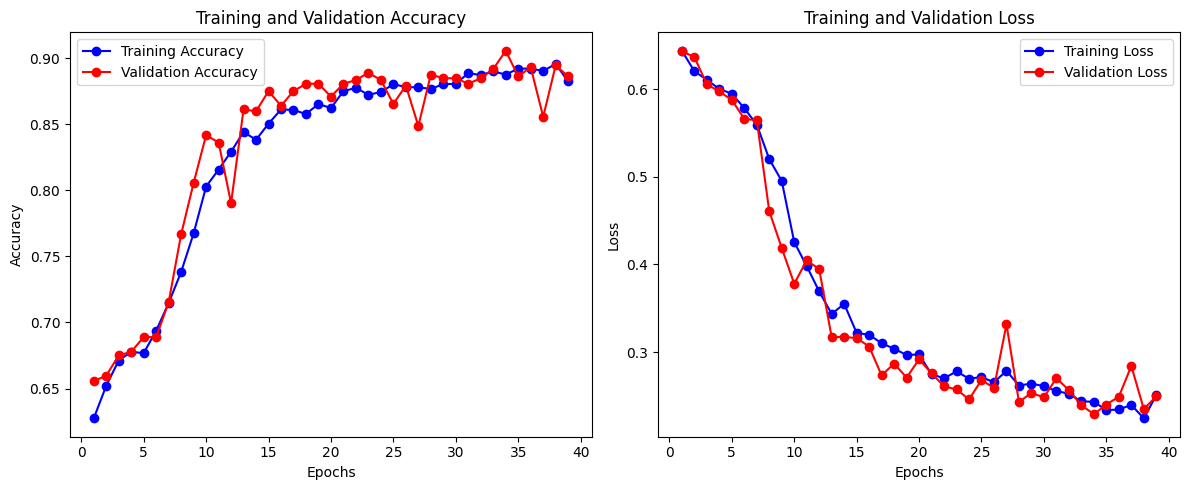

In [24]:
import matplotlib.pyplot as plt

# 訓練履歴を可視化
def plot_training_history(history):
    """AccuracyとLossのグラフを表示"""
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracyのプロット
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Lossのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# グラフを表示
plot_training_history(history)


In [25]:
import time
import os
import tensorflow as tf

# モデルの保存先パス
MODEL_SAVE_PATH = "trained_1d_cnn_model.keras"

# モデルサイズの計測
def calculate_model_size(model, save_path=MODEL_SAVE_PATH):
    # model.save(save_path)  # 一時的にモデルを保存
    model_size = os.path.getsize(save_path) / (1024 * 1024)  # サイズをMB単位で計測
    # os.remove(save_path)  # 保存したモデルを削除
    return model_size

# 推論時間の計測
def measure_inference_time(model, sample_input, num_trials=100):
    """
    モデル推論の時間を計測
    - model: 計測するモデル
    - sample_input: モデルへの入力データ
    - num_trials: 推論を繰り返す回数
    """
    # TensorFlowのキャッシュをクリア
    tf.keras.backend.clear_session()

    # 推論の時間を計測
    start_time = time.time()
    for _ in range(num_trials):
        _ = model.predict(sample_input, verbose=0)
    total_time = time.time() - start_time
    avg_time = total_time / num_trials
    return avg_time

# モデルサイズの評価
model_size = calculate_model_size(model)
print(f"モデルサイズ: {model_size:.2f} MB")

# 推論時間の評価
# サンプル入力データの作成（1秒の音声データを想定）
sample_input = tf.random.normal((1, SAMPLE_RATE * DURATION, 1))  # バッチサイズ1の入力
inference_time = measure_inference_time(model, sample_input)
print(f"1サンプルあたりの平均推論時間: {inference_time:.4f} 秒")


モデルサイズ: 1.83 MB
1サンプルあたりの平均推論時間: 0.0821 秒


# 6. モデルの評価
保存形式が.kerasの場合も.h5の場合も、以下の方法でロードできます。
テストデータでモデルの性能を評価します。

In [26]:
from tensorflow.keras.models import load_model

# 保存済みモデルのロード
loaded_model = load_model(MODEL_SAVE_PATH)
print("モデルをロードしました。")
loaded_model.summary()


# テストデータで評価
test_loss, test_acc = model.evaluate(X_test, y_test_enc)
print(f"テストデータの損失: {test_loss}")
print(f"テストデータの精度: {test_acc}")


モデルをロードしました。


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 79998, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 39999, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 39997, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19998, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 19996, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 470,024 (1.79 MB)

 Trainable params: 156,674 (612.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 313,350 (1.20 MB)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8913 - loss: 0.2299
テストデータの損失: 0.2290145307779312
テストデータの精度: 0.9055555462837219


# 7. 推論
新しい音声データをモデルで分類します。

In [27]:
# 推論関数
def predict_audio(file_path):
    y, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    # 長さを統一（ゼロパディング）
    if len(y) < SAMPLE_RATE * DURATION:
        y = np.pad(y, (0, SAMPLE_RATE * DURATION - len(y)))
    # 正規化
    y = y / np.max(np.abs(y))
    # モデルに入力できる形にリシェイプ
    y = y.reshape(1, -1, 1)
    # 推論
    predictions = model.predict(y)
    # ラベルをデコード
    predicted_label = encoder.inverse_transform([np.argmax(predictions)])
    return predicted_label[0]

# 推論例
test_file = "./ESC-50/ESC-50-master/audio/1-100032-A-0.wav"
print(f"推論結果: {predict_audio(test_file)}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
推論結果: 0


In [28]:
import random
import os
import pandas as pd

# ディレクトリと設定
AUDIO_DIR = "./ESC-50/ESC-50-master/audio/"  # 音声ファイルのディレクトリ
META_FILE = "./ESC-50/ESC-50-master/meta/esc50.csv"  # メタデータファイル
N = 5  # ランダムに選ぶファイル数

# 音声ファイルのランダム選択とラベルの取得
def list_random_files_with_labels(audio_dir, meta_file, n):
    """指定されたディレクトリからランダムにN個の音声ファイルと対応するラベルをリストアップする"""
    # メタデータの読み込み
    metadata = pd.read_csv(meta_file)

    # 音声ファイルリストの作成
    audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith(".wav")]

    # ランダムに選択
    selected_files = random.sample(audio_files, n)

    # ファイル名に基づいてラベルを取得
    selected_files_with_labels = []
    for file_path in selected_files:
        file_name = os.path.basename(file_path)
        label = metadata[metadata["filename"] == file_name]["category"].values[0]
        selected_files_with_labels.append((file_path, label))

    return selected_files_with_labels

selected_files_with_labels = list_random_files_with_labels(AUDIO_DIR, META_FILE, N)

# 結果の表示
for file_path, label in selected_files_with_labels:
    print(f"File: {file_path}, Label: {label}")


File: ./ESC-50/ESC-50-master/audio/3-124376-A-3.wav, Label: cow
File: ./ESC-50/ESC-50-master/audio/1-88807-A-39.wav, Label: glass_breaking
File: ./ESC-50/ESC-50-master/audio/3-145577-A-43.wav, Label: car_horn
File: ./ESC-50/ESC-50-master/audio/5-127990-A-2.wav, Label: pig
File: ./ESC-50/ESC-50-master/audio/3-151206-A-23.wav, Label: breathing


選ばれた音声ファイル:
1: ./ESC-50/ESC-50-master/audio/3-124376-A-3.wav (Label: cow)
2: ./ESC-50/ESC-50-master/audio/1-88807-A-39.wav (Label: glass_breaking)
3: ./ESC-50/ESC-50-master/audio/3-145577-A-43.wav (Label: car_horn)
4: ./ESC-50/ESC-50-master/audio/5-127990-A-2.wav (Label: pig)
5: ./ESC-50/ESC-50-master/audio/3-151206-A-23.wav (Label: breathing)


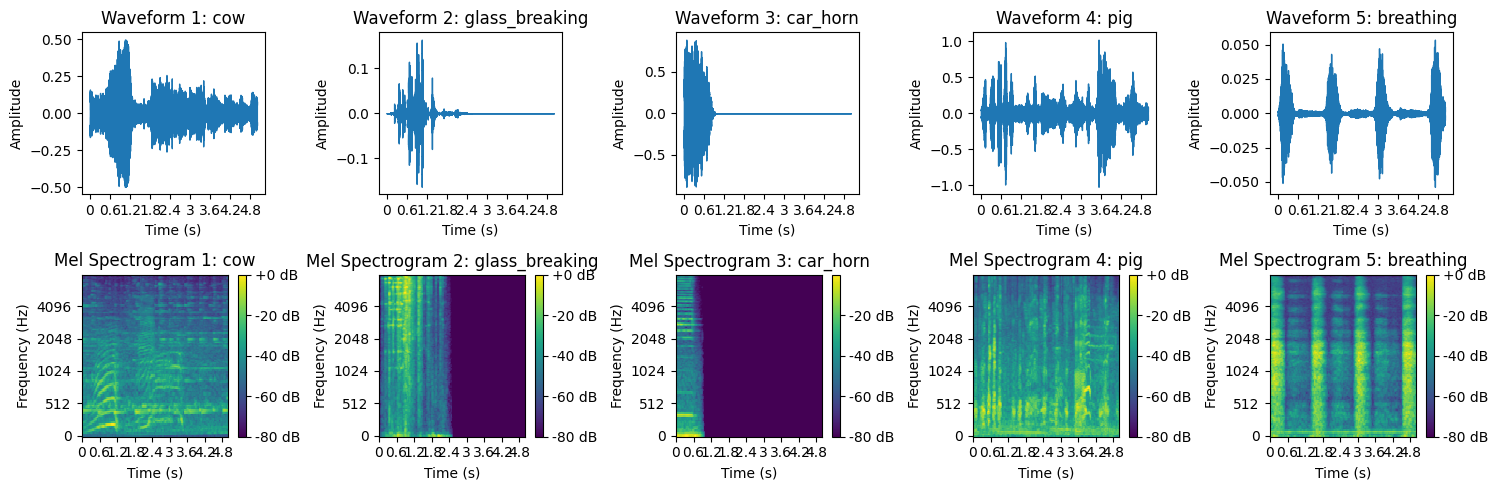

Audio Playback: ./ESC-50/ESC-50-master/audio/3-124376-A-3.wav (Label: cow)


Audio Playback: ./ESC-50/ESC-50-master/audio/1-88807-A-39.wav (Label: glass_breaking)


Audio Playback: ./ESC-50/ESC-50-master/audio/3-145577-A-43.wav (Label: car_horn)


Audio Playback: ./ESC-50/ESC-50-master/audio/5-127990-A-2.wav (Label: pig)


Audio Playback: ./ESC-50/ESC-50-master/audio/3-151206-A-23.wav (Label: breathing)


In [29]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Audio, display

# プロット関数
def plot_audio_and_spectrograms(file_paths_with_labels, max_columns=5):
    num_files = len(file_paths_with_labels)
    num_rows = (num_files + max_columns - 1) // max_columns

    plt.figure(figsize=(15, 5 * num_rows))

    for idx, (file_path, label) in enumerate(file_paths_with_labels):
        # 音声データの読み込み
        y, sr = librosa.load(file_path, sr=16000)  # サンプリングレートを16kHzに指定

        # スペクトログラムの計算
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # プロット位置の計算
        row = idx // max_columns
        col = idx % max_columns

        # 波形プロット
        plt.subplot(num_rows * 2, max_columns, row * max_columns * 2 + col + 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Waveform {idx + 1}: {label}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # スペクトログラムプロット
        plt.subplot(num_rows * 2, max_columns, row * max_columns * 2 + max_columns + col + 1)
        librosa.display.specshow(log_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis")
        plt.title(f"Mel Spectrogram {idx + 1}: {label}")
        plt.colorbar(format="%+2.0f dB")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

    # 音声の再生
    for file_path, label in file_paths_with_labels:
        print(f"Audio Playback: {file_path} (Label: {label})")
        y, sr = librosa.load(file_path, sr=16000)
        display(Audio(y, rate=sr))

print("選ばれた音声ファイル:")
for idx, (file_path, label) in enumerate(selected_files_with_labels, 1):
    print(f"{idx}: {file_path} (Label: {label})")

plot_audio_and_spectrograms(selected_files_with_labels)


In [30]:
# 推論
for idx, (file_path, label) in enumerate(selected_files_with_labels, 1):
    print(f"{idx}: {file_path} (Label: {label})")
    print(f"推論結果: {predict_audio(file_path)}")


1: ./ESC-50/ESC-50-master/audio/3-124376-A-3.wav (Label: cow)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
推論結果: 0
2: ./ESC-50/ESC-50-master/audio/1-88807-A-39.wav (Label: glass_breaking)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
推論結果: 0
3: ./ESC-50/ESC-50-master/audio/3-145577-A-43.wav (Label: car_horn)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
推論結果: 0
4: ./ESC-50/ESC-50-master/audio/5-127990-A-2.wav (Label: pig)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
推論結果: 0
5: ./ESC-50/ESC-50-master/audio/3-151206-A-23.wav (Label: breathing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
推論結果: 0


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


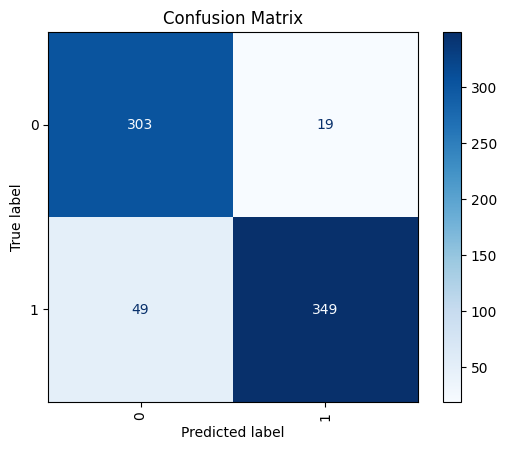

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 予測ラベルの取得
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 混同行列の計算
cm = confusion_matrix(y_test_enc, y_pred_classes, labels=range(len(encoder.classes_)))

# 混同行列の表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


# スタンドアローンで動作するコード
今後、別のインスタンスに移行する予定。

In [ ]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import files
from google.colab import output
from IPython.display import display, Audio
import os

# ハイパーパラメータ
SAMPLE_RATE = 16000
DURATION = 3  # 秒数
MODEL_SAVE_PATH = "trained_1d_cnn_model.keras"

# 音声録音
def record_audio():
    print("録音を開始します。終了するには「録音を停止」を押してください。")
    output.record()
    display(Audio())

# 音声ファイルのアップロード
def upload_audio():
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]
    print(f"アップロードされたファイル: {file_path}")
    return file_path

# 音声の前処理
def preprocess_audio(file_path):
    # 音声ファイルを読み込み
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # 指定された長さに切り詰めるか、ゼロ埋め
    max_length = SAMPLE_RATE * DURATION
    if len(y) > max_length:
        y = y[:max_length]
    else:
        y = np.pad(y, (0, max_length - len(y)))

    # モデル入力形式に整形
    return y.reshape(1, -1, 1)

# 推論
def predict_audio(file_path, model):
    audio_input = preprocess_audio(file_path)
    predictions = model.predict(audio_input)
    predicted_class = np.argmax(predictions)
    return predictions, predicted_class

# ラベル変換
def decode_predictions(predicted_class, labels):
    predicted_label = labels[predicted_class]
    return predicted_label

# メイン処理
def main():
    # モデルのロード
    print("モデルをロードしています...")
    model = load_model(MODEL_SAVE_PATH)
    print("モデルをロードしました。")

    # ラベル定義（必要に応じて変更）
    labels = ["クラス1", "クラス2"]  # クラス名を定義

    # 音声録音またはアップロードを選択
    print("音声を録音する場合は 'r' を、アップロードする場合は 'u' を入力してください。")
    choice = input("選択: ").strip().lower()

    if choice == 'r':
        record_audio()
        print("録音されたファイルを手動でファイルシステムに保存してください。")
        print("録音ファイルを 'upload_audio' 関数でアップロードしてください。")
        return
    elif choice == 'u':
        file_path = upload_audio()
    else:
        print("無効な選択です。終了します。")
        return

    # 推論
    print("推論を開始します...")
    predictions, predicted_class = predict_audio(file_path, model)
    predicted_label = decode_predictions(predicted_class, labels)

    print(f"推論結果: クラス {predicted_class} ({predicted_label})")
    print(f"信頼スコア: {predictions[0][predicted_class]:.4f}")

# 実行
main()


モデルをロードしています...
モデルをロードしました。
音声を録音する場合は 'r' を、アップロードする場合は 'u' を入力してください。
選択: u


Saving レコーディング (2).m4a to レコーディング (2).m4a
アップロードされたファイル: レコーディング (2).m4a
推論を開始します...


<ipython-input-85-aeb1ec9655ad>:30: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
推論結果: クラス 0 (クラス1)
信頼スコア: 0.8048


メモ：
閾値変えてみる、データを集める